In [176]:
import pandas as pd
import numpy as np

data_path = "data/"

In [177]:
df_train = pd.read_csv(data_path + "time_series_train_data.csv")
df_test = pd.read_csv(data_path + "time_series_test_data.csv")
df_train

,Year,Month,Location Group,District,crime_count,holiday_count,sin_month,cos_month,crime_count_lag1,crime_count_lag2,crime_count_lag3,crime_count_lag6,crime_count_lag12,crime_count_ma3,crime_count_ma6
0,2019,1,EDUCATIONAL,1.0,22,2,0.0,1.000000,19.0,13.0,16.0,21.0,6.0,16.000000,17.500000
1,2019,1,EDUCATIONAL,2.0,19,2,0.0,1.000000,13.0,16.0,15.0,24.0,18.0,14.666667,18.333333
2,2019,1,EDUCATIONAL,3.0,13,2,0.0,1.000000,16.0,15.0,21.0,43.0,19.0,17.333333,23.333333
3,2019,1,EDUCATIONAL,4.0,40,2,0.0,1.000000,31.0,22.0,19.0,15.0,17.0,24.000000,19.333333
4,2019,1,EDUCATIONAL,5.0,16,2,0.0,1.000000,15.0,21.0,21.0,37.0,20.0,19.000000,26.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14422,2023,12,TRANSPORTATION,19.0,29,1,-0.5,0.866025,8.0,12.0,16.0,30.0,36.0,12.000000,22.166667
14423,2023,12,TRANSPORTATION,20.0,8,1,-0.5,0.866025,12.0,16.0,34.0,67.0,32.0,20.666667,32.000000
14424,2023,12,TRANSPORTATION,22.0,12,1,-0.5,0.866025,16.0,34.0,33.0,38.0,118.0,27.666667,36.333333
14425,2023,12,TRANSPORTATION,24.0,16,1,-0.5,0.866025,34.0,33.0,30.0,35.0,43.0,32.333333,39.500000


In [178]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [179]:
categorical_cols = ["Location Group", "District"]
numerical_cols = [
    "crime_count_lag1",
    "crime_count_lag2",
    "crime_count_lag3",
    "crime_count_lag12",
    "crime_count_ma3",
    "crime_count_ma6",
    "holiday_count",
    "sin_month",
    "cos_month",
    "Year",
    "Month",
]

# Split features and target
X_train = df_train[categorical_cols + numerical_cols]
y_train = df_train["crime_count"]
X_test = df_test[categorical_cols + numerical_cols]
y_test = df_test["crime_count"]

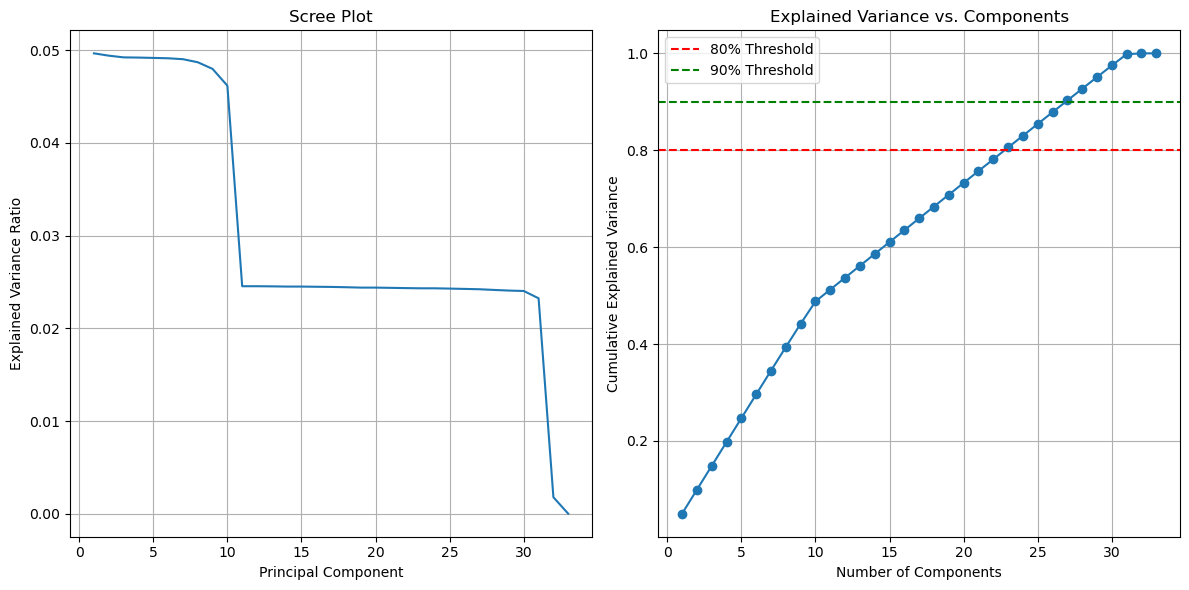

In [180]:
from sklearn.decomposition import PCA

ohc = OneHotEncoder(handle_unknown="ignore")
X_coded = ohc.fit_transform(X_train[categorical_cols])
pca = PCA(n_components=X_coded.shape[1] - 1, random_state=42)
pca_result = pca.fit_transform(X_coded)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(
    range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_
)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.grid(True)

# Plot the cumulative explained variance
plt.subplot(1, 2, 2)
plt.plot(
    range(1, len(pca.explained_variance_ratio_) + 1),
    np.cumsum(pca.explained_variance_ratio_),
    marker="o",
)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Components")
plt.axhline(y=0.8, color="r", linestyle="--", label="80% Threshold")
plt.axhline(y=0.9, color="g", linestyle="--", label="90% Threshold")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [181]:
cat_pipe = Pipeline(
    [
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat_pipe", cat_pipe, categorical_cols),
    ]
)

model = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())],
)

In [182]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['crime_count_lag1',
                                                   'crime_count_lag2',
                                                   'crime_count_lag3',
                                                   'crime_count_lag12',
                                                   'crime_count_ma3',
                                                   'crime_count_ma6',
                                                   'holiday_count', 'sin_month',
                                                   'cos_month', 'Year',
                                                   'Month']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Location Group',
                                                   'District'])])),
                ('regressor', LinearRegression())])

In [183]:
lr_train_pred = model.predict(X_train)
lr_pred = model.predict(X_test)

In [184]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# Calculate regression metrics
rmse = root_mean_squared_error(y_test, lr_pred)
mae = mean_absolute_error(y_test, lr_pred)
r2 = r2_score(y_test, lr_pred)
mean_value = y_test.mean()
print(mean_value)
mae_percentage = (mae / mean_value) * 100

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Mean Absolute Error Percentage: {mae_percentage:.2f}%")

88.79227053140097
Root Mean Squared Error: 49.88
Mean Absolute Error: 30.62
R² Score: 0.86
Mean Absolute Error Percentage: 34.48%


# Random Forest Regressor


In [185]:
from sklearn.ensemble import RandomForestRegressor

# Same preprocessing pipeline, but switch out the regressor
rf_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", RandomForestRegressor(n_estimators=100, random_state=42)),
    ]
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
rf_train_pred = rf_model.predict(X_train)
rf_pred = rf_model.predict(X_test)

In [186]:
# Evaluate the model
rf_rmse = root_mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)
rf_mae_percentage = (rf_mae / y_test.mean()) * 100

print(f"Random Forest Results:")
print(f"Root Mean Squared Error: {rf_rmse:.2f}")
print(f"Mean Absolute Error: {rf_mae:.2f}")
print(f"R² Score: {rf_r2:.2f}")
print(f"Mean Absolute Error Percentage: {rf_mae_percentage:.2f}%")

Random Forest Results:
Root Mean Squared Error: 26.00
Mean Absolute Error: 13.62
R² Score: 0.96
Mean Absolute Error Percentage: 15.33%


In [187]:
from xgboost import XGBRegressor

xg_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "regressor",
            XGBRegressor(
                n_estimators=200,
                learning_rate=0.1,
                max_depth=7,
                min_child_weight=5,
                gamma=0.1,
                random_state=42,
            ),
        ),
    ]
)
xg_model.fit(X_train, y_train)
xg_train_pred = xg_model.predict(X_train)
xg_pred = xg_model.predict(X_test)

In [188]:
# Evaluate the model
xg_rmse = root_mean_squared_error(y_test, xg_pred)
xg_mae = mean_absolute_error(y_test, xg_pred)
xg_r2 = r2_score(y_test, xg_pred)
xg_mae_percentage = (xg_mae / y_test.mean()) * 100
print(f"XGBoost Results:")
print(f"Root Mean Squared Error: {xg_rmse:.2f}")
print(f"Mean Absolute Error: {xg_mae:.2f}")
print(f"R² Score: {xg_r2:.2f}")
print(f"Mean Absolute Error Percentage: {xg_mae_percentage:.2f}%")

XGBoost Results:
Root Mean Squared Error: 23.13
Mean Absolute Error: 13.06
R² Score: 0.97
Mean Absolute Error Percentage: 14.71%


In [189]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    "regressor__n_estimators": [200],
    "regressor__learning_rate": [0.1],
    "regressor__max_depth": [5, 7, 9],
    "regressor__min_child_weight": [5],
    "regressor__gamma": [0.1],
}

# Create the pipeline with XGBRegressor
xg_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", XGBRegressor(random_state=42))]
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xg_model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring="neg_mean_squared_error",
    n_jobs=-1,  # Use all available cores
    verbose=1,  # Display progress
)

# Fit the grid search to the data
print("Starting grid search...")
grid_search.fit(X_train, y_train)
print("Grid search completed!")

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(f"Best parameters: {best_params}")

# Evaluate the best model
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Training metrics
train_rmse = root_mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Testing metrics
test_rmse = root_mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\nModel Performance:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Testing RMSE: {test_rmse:.4f}")
print(f"Testing R²: {test_r2:.4f}")

# Store residuals for plotting
xg_res = y_test - y_test_pred

Starting grid search...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Grid search completed!
Best parameters: {'regressor__gamma': 0.1, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 7, 'regressor__min_child_weight': 5, 'regressor__n_estimators': 200}

Model Performance:
Training RMSE: 10.1532
Training R²: 0.9939
Testing RMSE: 23.1319
Testing R²: 0.9705


In [190]:
df_train["lr_pred"] = lr_train_pred
df_train["rf_pred"] = rf_train_pred
df_train["xg_pred"] = xg_train_pred
df_test["lr_pred"] = lr_pred
df_test["rf_pred"] = rf_pred
df_test["xg_pred"] = xg_pred

# Add residuals (actual - predicted)
df_train["lr_res"] = df_train["crime_count"] - df_train["lr_pred"]
df_train["rf_res"] = df_train["crime_count"] - df_train["rf_pred"]
df_train["xg_res"] = df_train["crime_count"] - df_train["xg_pred"]
df_test["lr_res"] = df_test["crime_count"] - df_test["lr_pred"]
df_test["rf_res"] = df_test["crime_count"] - df_test["rf_pred"]
df_test["xg_res"] = df_test["crime_count"] - df_test["xg_pred"]

Montly MAE and MAE Accuracy for each model on test data:
Linear Regression MAE:  30.616490055734044
Linear Regression MAE Accuracy:  0.3448103069388981
Random Forest MAE:  13.615772946859902
Random Forest MAE Accuracy:  0.15334412404787812
XGBoost MAE:  13.057267189025879
XGBoost MAE Accuracy:  0.1470540972866353


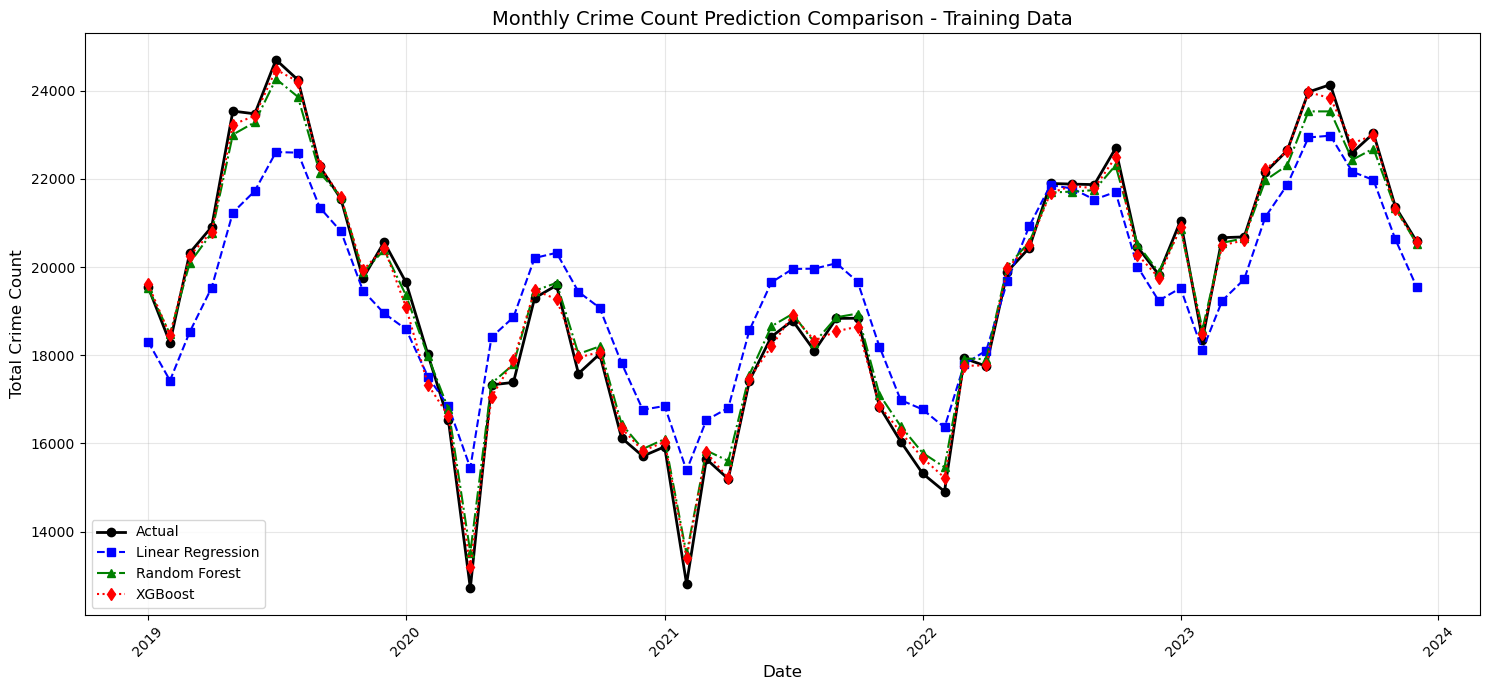

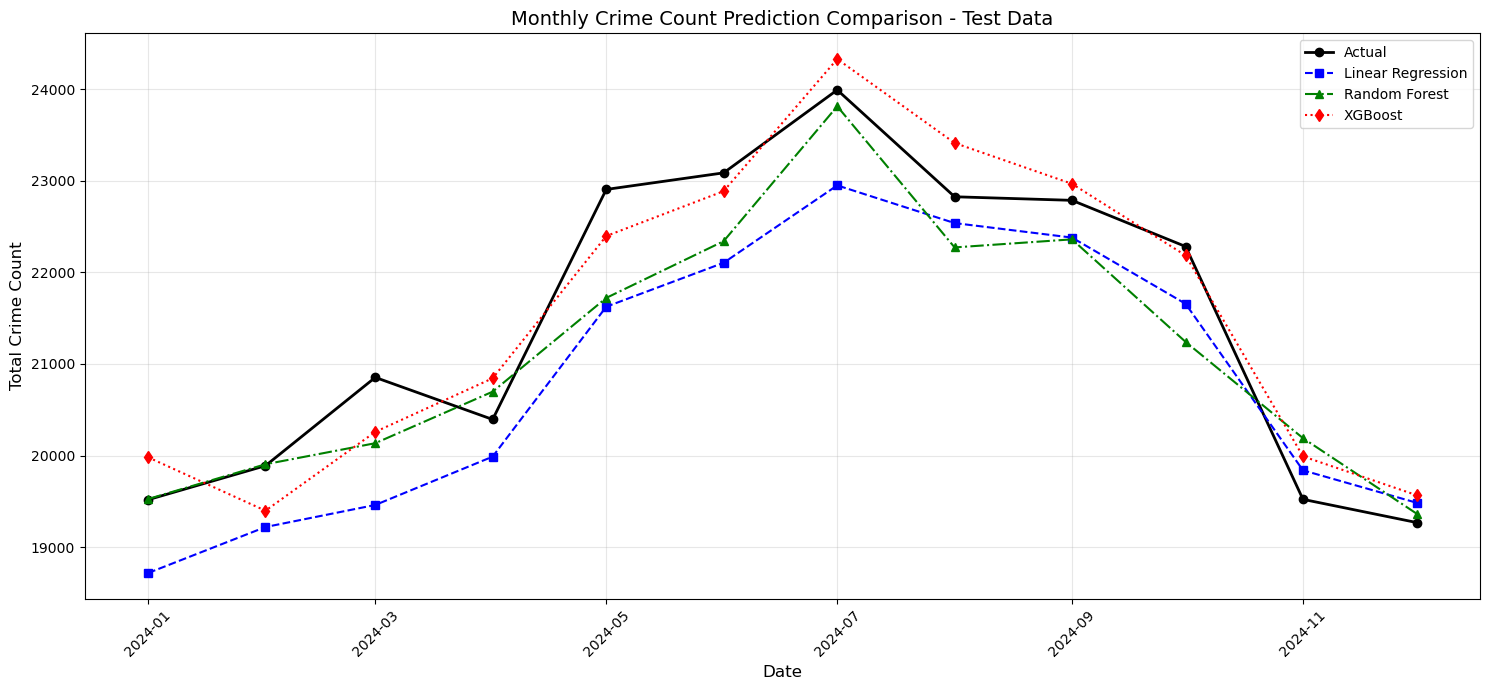

In [191]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# 1. MONTHLY AGGREGATION PLOTS
# ============================

# Aggregate by month
monthly_train = (
    df_train.groupby(["Year", "Month"])
    .agg({"crime_count": "sum", "lr_pred": "sum", "rf_pred": "sum", "xg_pred": "sum"})
    .reset_index()
)

monthly_test = (
    df_test.groupby(["Year", "Month"])
    .agg({"crime_count": "sum", "lr_pred": "sum", "rf_pred": "sum", "xg_pred": "sum"})
    .reset_index()
)

# Create date columns
monthly_train["date"] = pd.to_datetime(
    monthly_train["Year"].astype(str) + "-" + monthly_train["Month"].astype(str) + "-01"
)
monthly_test["date"] = pd.to_datetime(
    monthly_test["Year"].astype(str) + "-" + monthly_test["Month"].astype(str) + "-01"
)

# Sort by date
monthly_train = monthly_train.sort_values("date")
monthly_test = monthly_test.sort_values("date")

# print mean absolute error and mean absolute error accuracy for each model
print("Montly MAE and MAE Accuracy for each model on test data:")
print("Linear Regression MAE: ", mean_absolute_error(y_test, lr_pred))
print(
    "Linear Regression MAE Accuracy: ",
    mean_absolute_error(y_test, lr_pred) / y_test.mean(),
)
print("Random Forest MAE: ", mean_absolute_error(y_test, rf_pred))
print(
    "Random Forest MAE Accuracy: ", mean_absolute_error(y_test, rf_pred) / y_test.mean()
)
print("XGBoost MAE: ", mean_absolute_error(y_test, xg_pred))
print("XGBoost MAE Accuracy: ", mean_absolute_error(y_test, xg_pred) / y_test.mean())
# Plot monthly comparison - Training data
plt.figure(figsize=(15, 7))
plt.plot(
    monthly_train["date"],
    monthly_train["crime_count"],
    marker="o",
    linewidth=2,
    label="Actual",
    color="black",
)
plt.plot(
    monthly_train["date"],
    monthly_train["lr_pred"],
    marker="s",
    linestyle="--",
    label="Linear Regression",
    color="blue",
)
plt.plot(
    monthly_train["date"],
    monthly_train["rf_pred"],
    marker="^",
    linestyle="-.",
    label="Random Forest",
    color="green",
)
plt.plot(
    monthly_train["date"],
    monthly_train["xg_pred"],
    marker="d",
    linestyle=":",
    label="XGBoost",
    color="red",
)
plt.title("Monthly Crime Count Prediction Comparison - Training Data", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Crime Count", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("./figure/monthly_comparison_train_data.pdf", format="pdf")
plt.show()

# Plot monthly comparison - Test data
plt.figure(figsize=(15, 7))
plt.plot(
    monthly_test["date"],
    monthly_test["crime_count"],
    marker="o",
    linewidth=2,
    label="Actual",
    color="black",
)
plt.plot(
    monthly_test["date"],
    monthly_test["lr_pred"],
    marker="s",
    linestyle="--",
    label="Linear Regression",
    color="blue",
)
plt.plot(
    monthly_test["date"],
    monthly_test["rf_pred"],
    marker="^",
    linestyle="-.",
    label="Random Forest",
    color="green",
)
plt.plot(
    monthly_test["date"],
    monthly_test["xg_pred"],
    marker="d",
    linestyle=":",
    label="XGBoost",
    color="red",
)
plt.title("Monthly Crime Count Prediction Comparison - Test Data", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Crime Count", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("./figure/monthly_comparison_test_data.pdf", format="pdf")
plt.show()

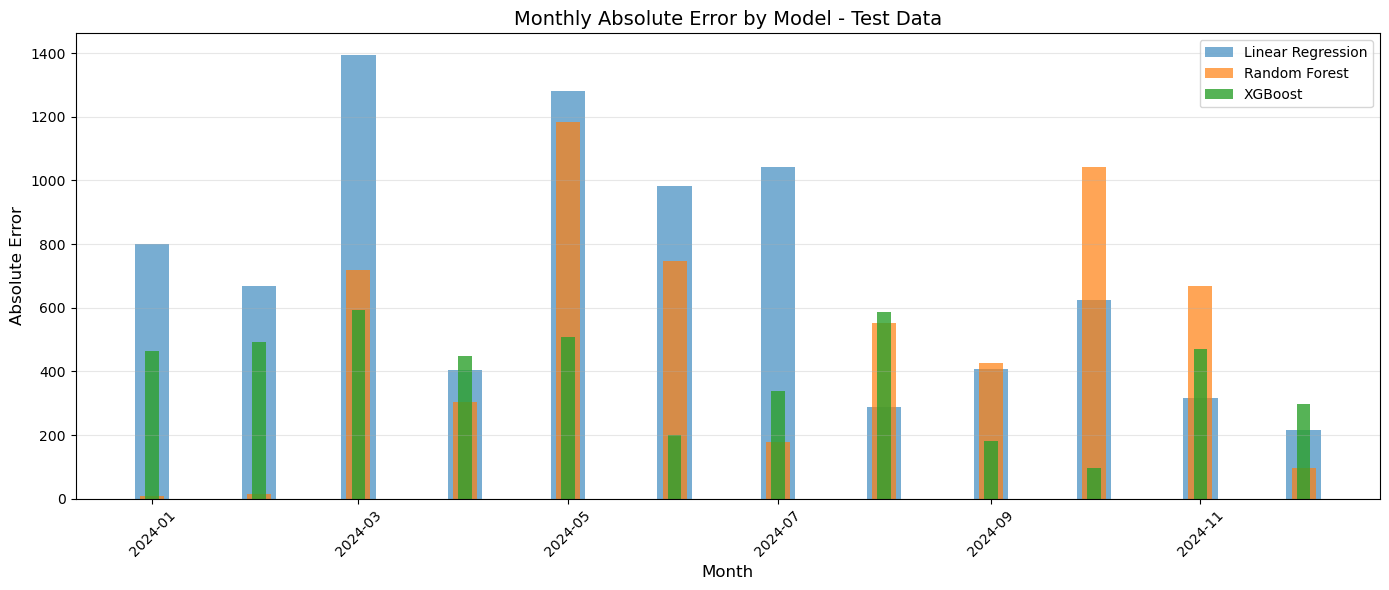

In [192]:
# 2. MODEL PERFORMANCE BY MONTH
# ============================

# Calculate monthly MAE for each model (test data)
monthly_test["lr_mae"] = abs(monthly_test["crime_count"] - monthly_test["lr_pred"])
monthly_test["rf_mae"] = abs(monthly_test["crime_count"] - monthly_test["rf_pred"])
monthly_test["xg_mae"] = abs(monthly_test["crime_count"] - monthly_test["xg_pred"])

# Plot MAE by month
plt.figure(figsize=(14, 6))
plt.bar(
    monthly_test["date"],
    monthly_test["lr_mae"],
    width=10,
    alpha=0.6,
    label="Linear Regression",
)
plt.bar(
    monthly_test["date"],
    monthly_test["rf_mae"],
    width=7,
    alpha=0.7,
    label="Random Forest",
)
plt.bar(
    monthly_test["date"], monthly_test["xg_mae"], width=4, alpha=0.8, label="XGBoost"
)
plt.title("Monthly Absolute Error by Model - Test Data", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Absolute Error", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3, axis="y")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("./figure/monthly_absolute_error_by_model_test_data.pdf", format="pdf")
plt.show()

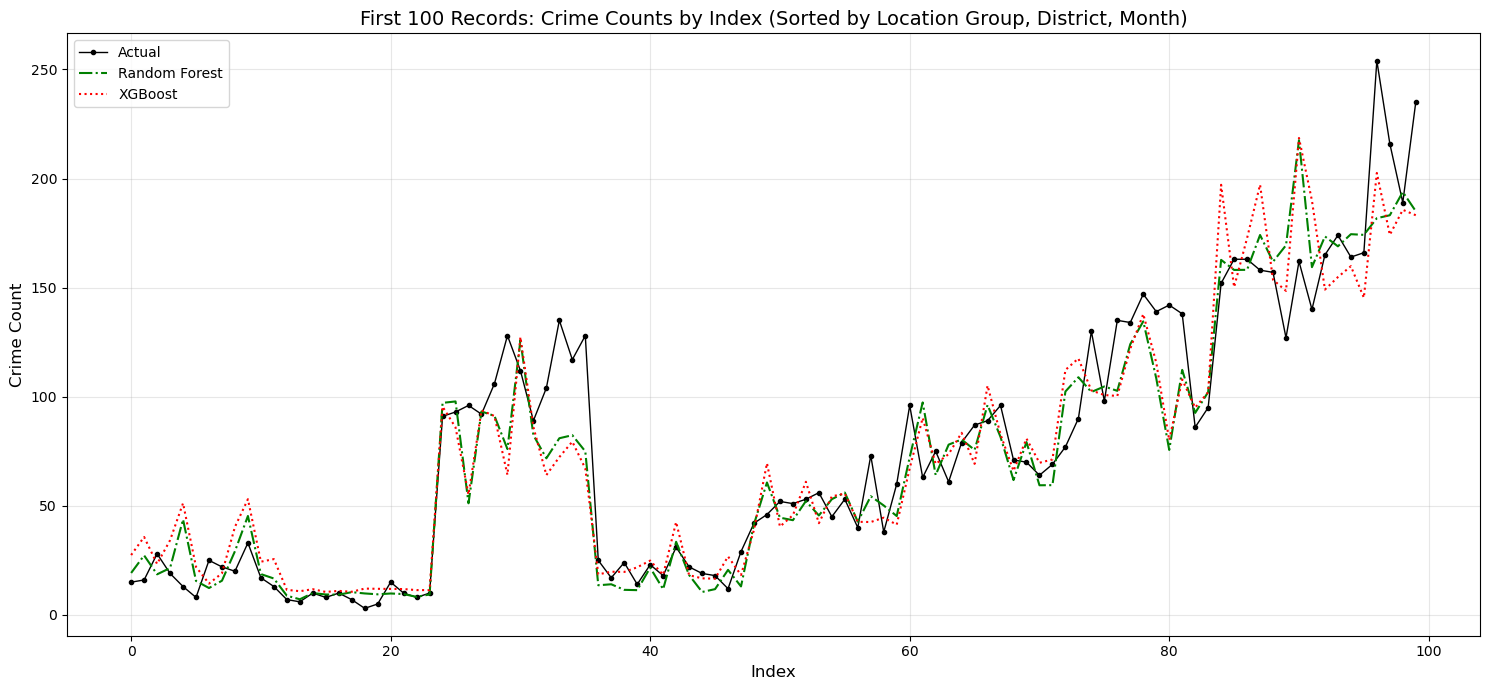

In [193]:
# 3. Plots based on index (first 100 indexes)

# Sort the test dataframe by a specific column (e.g., by District, then Month)
sorted_df = df_test.sort_values(["District", "Location Group", "Month"]).reset_index(
    drop=True
)

plt.figure(figsize=(15, 7))
plt.plot(
    sorted_df.index[:100],
    sorted_df["crime_count"][:100],
    marker="o",
    markersize=3,
    linewidth=1,
    label="Actual",
    color="black",
)
# plt.plot(sorted_df.index[:100], sorted_df['lr_pred'][:100], marker='', linestyle='--', label='Linear Regression', color='blue')
plt.plot(
    sorted_df.index[:100],
    sorted_df["rf_pred"][:100],
    marker="",
    linestyle="-.",
    label="Random Forest",
    color="green",
)
plt.plot(
    sorted_df.index[:100],
    sorted_df["xg_pred"][:100],
    marker="",
    linestyle=":",
    label="XGBoost",
    color="red",
)

plt.title(
    "First 100 Records: Crime Counts by Index (Sorted by Location Group, District, Month)",
    fontsize=14,
)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Crime Count", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("./figure/first_100_records_crime_counts_by_index.pdf", format="pdf")
plt.show()

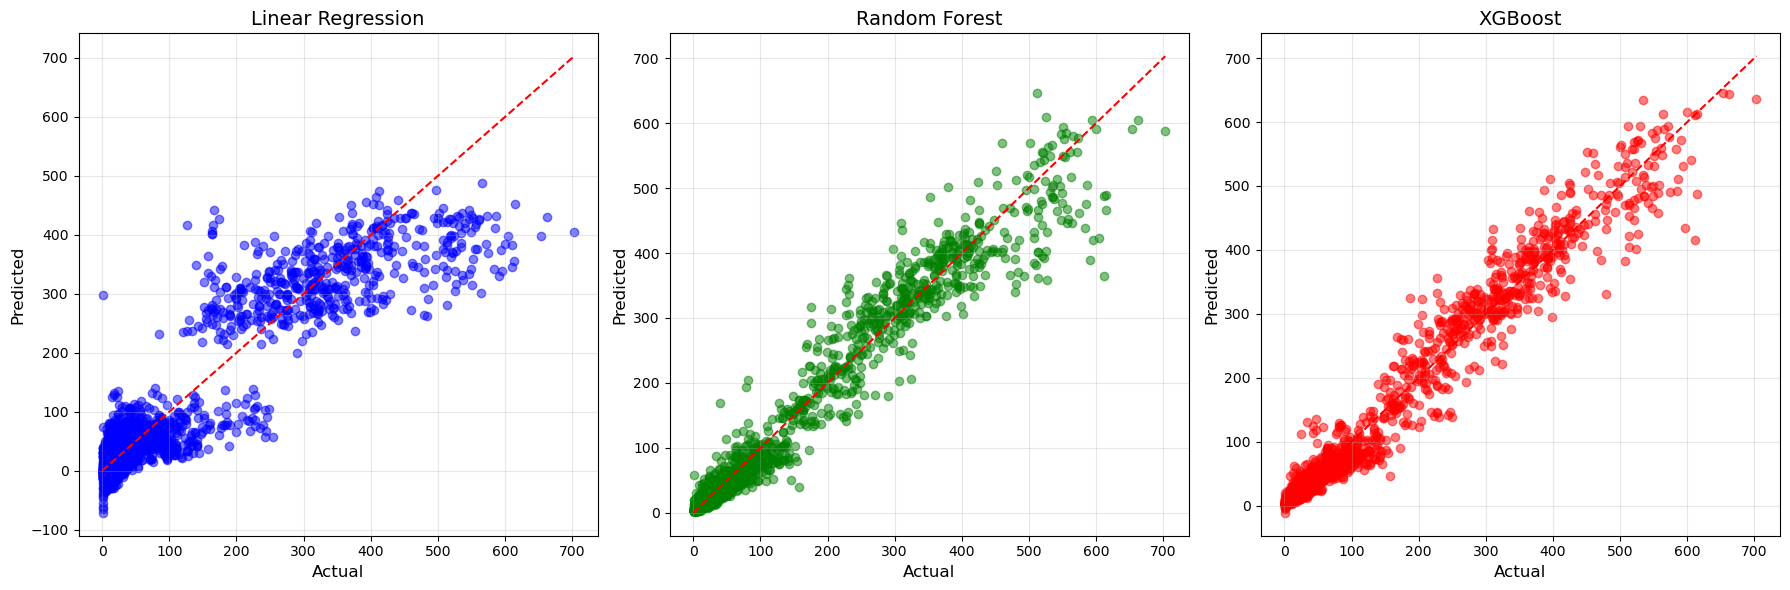

In [194]:
# 4. SCATTERPLOTS BY MODEL
# =======================

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Linear Regression
axes[0].scatter(df_test["crime_count"], df_test["lr_pred"], alpha=0.5, color="blue")
axes[0].plot(
    [0, df_test["crime_count"].max()], [0, df_test["crime_count"].max()], "r--"
)
axes[0].set_title("Linear Regression", fontsize=14)
axes[0].set_xlabel("Actual", fontsize=12)
axes[0].set_ylabel("Predicted", fontsize=12)
axes[0].grid(True, alpha=0.3)

# Random Forest
axes[1].scatter(df_test["crime_count"], df_test["rf_pred"], alpha=0.5, color="green")
axes[1].plot(
    [0, df_test["crime_count"].max()], [0, df_test["crime_count"].max()], "r--"
)
axes[1].set_title("Random Forest", fontsize=14)
axes[1].set_xlabel("Actual", fontsize=12)
axes[1].set_ylabel("Predicted", fontsize=12)
axes[1].grid(True, alpha=0.3)

# XGBoost
axes[2].scatter(df_test["crime_count"], df_test["xg_pred"], alpha=0.5, color="red")
axes[2].plot(
    [0, df_test["crime_count"].max()], [0, df_test["crime_count"].max()], "r--"
)
axes[2].set_title("XGBoost", fontsize=14)
axes[2].set_xlabel("Actual", fontsize=12)
axes[2].set_ylabel("Predicted", fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("./figure/scatterplots_by_model_test_data.pdf", format="pdf")
plt.show()

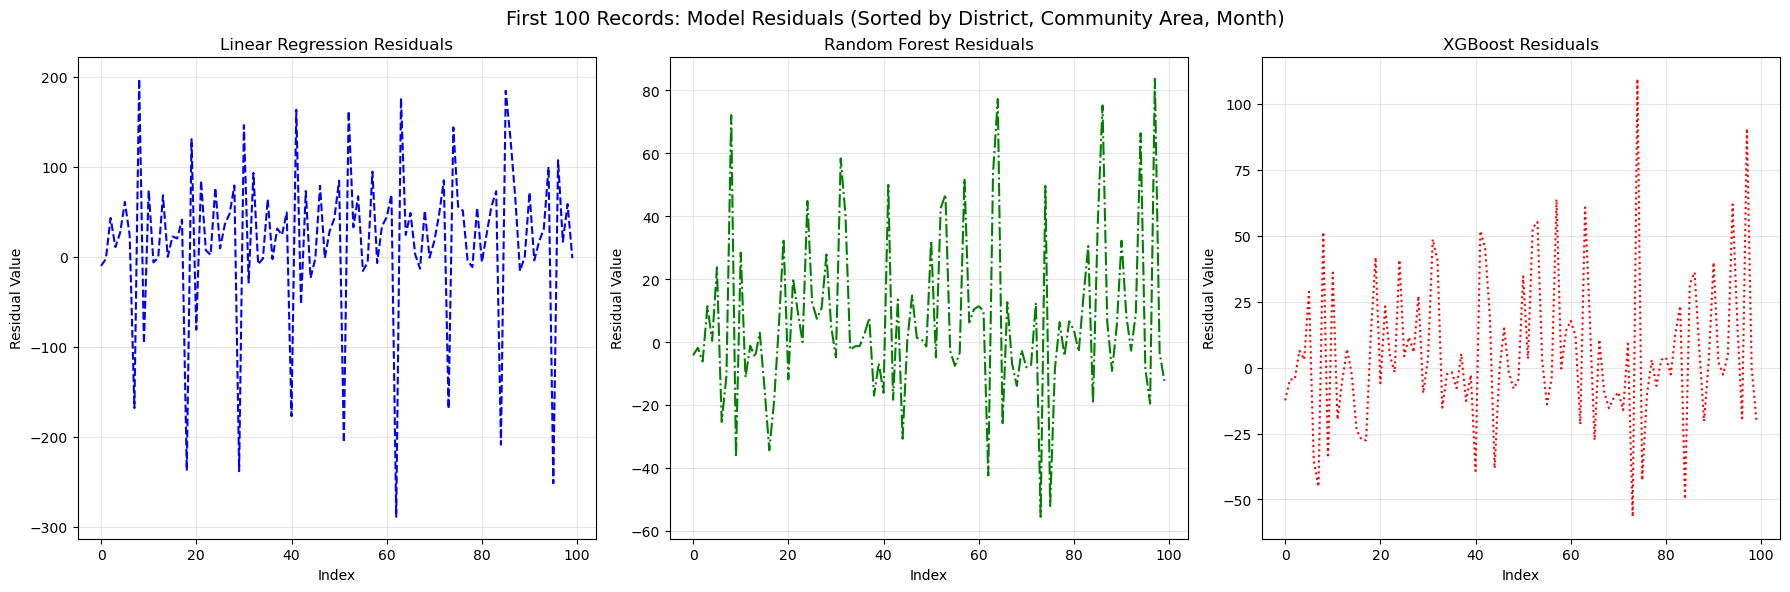

In [195]:
# 5. residuals plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Sort dataframe
sorted_df = df_test.sort_values(["District", "Month"]).reset_index(drop=True)

# Plot Linear Regression residuals
axes[0].plot(
    sorted_df.index[:100],
    sorted_df["lr_res"][:100],
    marker="",
    linestyle="--",
    color="blue",
)
axes[0].set_title("Linear Regression Residuals")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Residual Value")
axes[0].grid(True, alpha=0.3)

# Plot Random Forest residuals
axes[1].plot(
    sorted_df.index[:100],
    sorted_df["rf_res"][:100],
    marker="",
    linestyle="-.",
    color="green",
)
axes[1].set_title("Random Forest Residuals")
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Residual Value")
axes[1].grid(True, alpha=0.3)

# Plot XGBoost residuals
axes[2].plot(
    sorted_df.index[:100],
    sorted_df["xg_res"][:100],
    marker="",
    linestyle=":",
    color="red",
)
axes[2].set_title("XGBoost Residuals")
axes[2].set_xlabel("Index")
axes[2].set_ylabel("Residual Value")
axes[2].grid(True, alpha=0.3)

# Add a main title to the figure
fig.suptitle(
    "First 100 Records: Model Residuals (Sorted by District, Community Area, Month)",
    fontsize=14,
)

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Make room for the suptitle
plt.show()